## **IDX Exchange Home Price Prediction**
## **Task 2: Baseline Model Selection, Training & Evaluation**

#### 1. Imports & Setup

In [1]:
import warnings, gc, json, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import loguniform, randint

import matplotlib.pyplot as plt
from sklearn import tree

#### 2. Load and Merge Raw CRMLS Files

In [2]:
# Load cleaned data
csv_path = "../data/cleaned_enhanced.csv" if Path("../data/cleaned_enhanced.csv").exists() else "data/cleaned_enhanced.csv"
df = pd.read_csv(csv_path)

# Target / features
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df.columns), None)
assert target is not None, "Target column not found in cleaned_enhanced.csv"

y = pd.to_numeric(df[target], errors="coerce")
X = df.drop(columns=[target]).copy()

In [3]:
# Drop obvious IDs / text / date leakage columns
DROP_LIKE = {
    "ListingKey","ListingId","Matrix_Unique_ID","UniversalPropertyId",
    "MLS","PublicRemarks","PrivateRemarks","Directions","Photos","PhotoURL",
    "ModificationTimestamp","ListingContractDate","CloseDate"
}
drop_cols = [c for c in X.columns if any(k.lower() in c.lower() for k in DROP_LIKE)]
if drop_cols:
    X.drop(columns=drop_cols, inplace=True)

# Keep rows with numeric target
mask = y.notna()
X, y = X.loc[mask].reset_index(drop=True), y.loc[mask].reset_index(drop=True)

#### 3. Train Test Split

In [4]:
# Subsample for speed
N_SAMPLE = min(len(X), 40_000)
if len(X) > N_SAMPLE:
    samp = X.sample(N_SAMPLE, random_state=42).index
    X, y = X.loc[samp].reset_index(drop=True), y.loc[samp].reset_index(drop=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Save expected columns (used by predict_price)
models_path = Path("../models") if Path("../models").exists() else Path("models")
models_path.mkdir(parents=True, exist_ok=True)
with open(models_path / "expected_feature_columns.json", "w") as f:
    json.dump(X_train.columns.tolist(), f, indent=2)
print(f"Saved expected columns → {models_path / 'expected_feature_columns.json'}")

Saved expected columns → ../models/expected_feature_columns.json


#### 4. Build Preprocessors

In [6]:
# Feature partitions
num_cols = X_train.select_dtypes(include=[np.number, "bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()

# limit one-hot to LOW cardinality for linear model
CARD_LIMIT = 80
cat_low  = [c for c in cat_cols if X_train[c].nunique(dropna=True) <= CARD_LIMIT]
# cat_high would be dropped for Ridge

###### PREPROCESSORS

In [7]:
# Ridge --> take sparse input, then I need to keep OHE sparse=True
# Ridge: numeric + low-card OHE (sparse)
pre_ridge = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_low_ohe", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
        ]), cat_low),
    ],
    remainder="drop"
)

# RF: numeric + all cats Ordinal (dense)
pre_rf = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_ord", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)
    ],
    remainder="drop"
)

#### 5. Models & randomized tuning

In [8]:
#model 
ridge = Ridge(alpha=1.0, random_state=42)  # handles sparse, stable
rf = RandomForestRegressor(
    n_estimators=200,        # 200–400 --> start smaller for stability finger crossed
    max_depth=18,           # bound depth to prevent giant trees finger crossed
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

#### 6. Train Baseline Models

In [9]:
# Tune Ridge alpha (log-uniform)
ridge_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_ridge), ("model", ridge)]),
    param_distributions={"model__alpha": loguniform(1e-3, 1e3)},
    n_iter=10, cv=3, n_jobs=-1,
    scoring="neg_root_mean_squared_error", random_state=42
)
ridge_search.fit(X_train, y_train)
ridge_tuned = ridge_search.best_estimator_
print("Best Ridge alpha:", ridge_search.best_params_["model__alpha"])

# Tune Random Forest (n_estimators, depth, leaf size, feature subsampling)
rf_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_rf), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    param_distributions={
        "model__n_estimators": randint(200, 500),
        "model__max_depth": [None, 18, 30, 40],
        "model__min_samples_leaf": randint(1, 6),
        "model__max_features": ["sqrt", "log2", None],
    },
    n_iter=15, cv=3, n_jobs=-1,
    scoring="neg_root_mean_squared_error", random_state=42
)
rf_search.fit(X_train, y_train)
rf_tuned = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)


/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py

Best Ridge alpha: 3.90796715682288
Best RF params: {'model__max_depth': 40, 'model__max_features': None, 'model__min_samples_leaf': 3, 'model__n_estimators': 254}


#### 7) Metrics helpers + evaluation

In [10]:
def mdape(y_true, y_pred):
    """Median Absolute Percentage Error in % (robust to outliers)."""
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mask = (y_true != 0) & np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan
    return float(np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

def eval_pipe(name, pipe, X_te=X_test, y_te=y_test):
    """Evaluate a fitted pipeline on a test set and return key metrics."""
    y_pred = pipe.predict(X_te)
    return {
        "Model": name,
        "R2": float(r2_score(y_te, y_pred)),
        "MAE": float(mean_absolute_error(y_te, y_pred)),
        "RMSE": float(mean_squared_error(y_te, y_pred, squared=False)),
        "MdAPE (%)": float(mdape(y_te, y_pred)),
        "n_test": int(len(y_te)),
    }

# Evaluate tuned pipelines on the test split
ridge_m = eval_pipe("Ridge (tuned)", ridge_tuned)
rf_m    = eval_pipe("RandomForest (tuned)", rf_tuned)

# Rank by R² (desc) then RMSE (asc)
res_df = pd.DataFrame([ridge_m, rf_m]).sort_values(["R2", "RMSE"], ascending=[False, True])

# Pretty table in notebook environments
try:
    display(res_df.style.format({
        "R2": "{:.4f}", "MAE": "{:,.0f}", "RMSE": "{:,.0f}", "MdAPE (%)": "{:.2f}"
    }))
except Exception:
    pass

,Model,R2,MAE,RMSE,MdAPE (%),n_test
1,RandomForest (tuned),0.9941,"10,900","79,031",0.10,8000
0,Ridge (tuned),0.9619,"8,077","199,974",0.31,8000


In [11]:
# Always print a plain-text summary too
print("\n=== Test Metrics Summary ===")
for row in res_df.to_dict(orient="records"):
    print(f"{row['Model']}: R2={row['R2']:.4f}, RMSE=${row['RMSE']:,.0f}, "
          f"MAE=${row['MAE']:,.0f}, MdAPE={row['MdAPE (%)']:.2f}% (n={row['n_test']})")


=== Test Metrics Summary ===
RandomForest (tuned): R2=0.9941, RMSE=$79,031, MAE=$10,900, MdAPE=0.10% (n=8000)
Ridge (tuned): R2=0.9619, RMSE=$199,974, MAE=$8,077, MdAPE=0.31% (n=8000)


Model Choice (Tuned)

• Compared tuned Ridge (alpha) and Random Forest (n_estimators, max_depth, min_samples_leaf) with 3-fold CV.

• Evaluated on 20 % hold-out using R², MAE, RMSE.

• Winner = (auto-selected above) → saved as best_model.joblib; predict_price(...) uses it by default.

#### 8) Persist results + best tuned pipeline

In [12]:
res_df.to_csv(models_path / "baseline_models_results.csv", index=False)
with open(models_path / "baseline_models_summary.json", "w") as f:
    json.dump(res_df.to_dict(orient="records"), f, indent=2)

best_row  = res_df.iloc[0]  # top-scoring row (by our sort)
best_name = best_row["Model"]
best_pipe = ridge_tuned if "Ridge" in best_name else rf_tuned

joblib.dump(best_pipe, models_path / "best_model.joblib")
print(f"Winner → {best_name}")
print("Saved:", (models_path / "best_model.joblib").resolve())

Winner → RandomForest (tuned)
Saved: /Users/stephanie/Desktop/Home_Price_Predictions/models/best_model.joblib


#### Random Forest internals & feature importance

In [13]:
# Access the RandomForestRegressor inside my pipeline
rf_model = rf_tuned.named_steps["model"]

# Print basic info about the forest
print(f"RandomForest has {len(rf_model.estimators_)} trees")
print(f"Max depth of first tree: {rf_model.estimators_[0].tree_.max_depth}")

RandomForest has 254 trees
Max depth of first tree: 30


In [14]:
# Text-based summary of a single tree --> I need to make it safe and small
from sklearn.tree import export_text
tree_rules = export_text(rf_model.estimators_[0], max_depth=3)
print("\nSample of Decision Tree #0 (max_depth=3):\n")
print(tree_rules)


Sample of Decision Tree #0 (max_depth=3):

|--- feature_4 <= 2287500.00
|   |--- feature_4 <= 1093500.00
|   |   |--- feature_4 <= 675450.00
|   |   |   |--- feature_4 <= 479894.00
|   |   |   |   |--- truncated branch of depth 19
|   |   |   |--- feature_4 >  479894.00
|   |   |   |   |--- truncated branch of depth 25
|   |   |--- feature_4 >  675450.00
|   |   |   |--- feature_0 <= 11125000.00
|   |   |   |   |--- truncated branch of depth 27
|   |   |   |--- feature_0 >  11125000.00
|   |   |   |   |--- value: [9744000.00]
|   |--- feature_4 >  1093500.00
|   |   |--- feature_4 <= 1587500.00
|   |   |   |--- feature_4 <= 1342450.00
|   |   |   |   |--- truncated branch of depth 19
|   |   |   |--- feature_4 >  1342450.00
|   |   |   |   |--- truncated branch of depth 21
|   |   |--- feature_4 >  1587500.00
|   |   |   |--- feature_4 <= 1882991.00
|   |   |   |   |--- truncated branch of depth 17
|   |   |   |--- feature_4 >  1882991.00
|   |   |   |   |--- truncated branch of depth

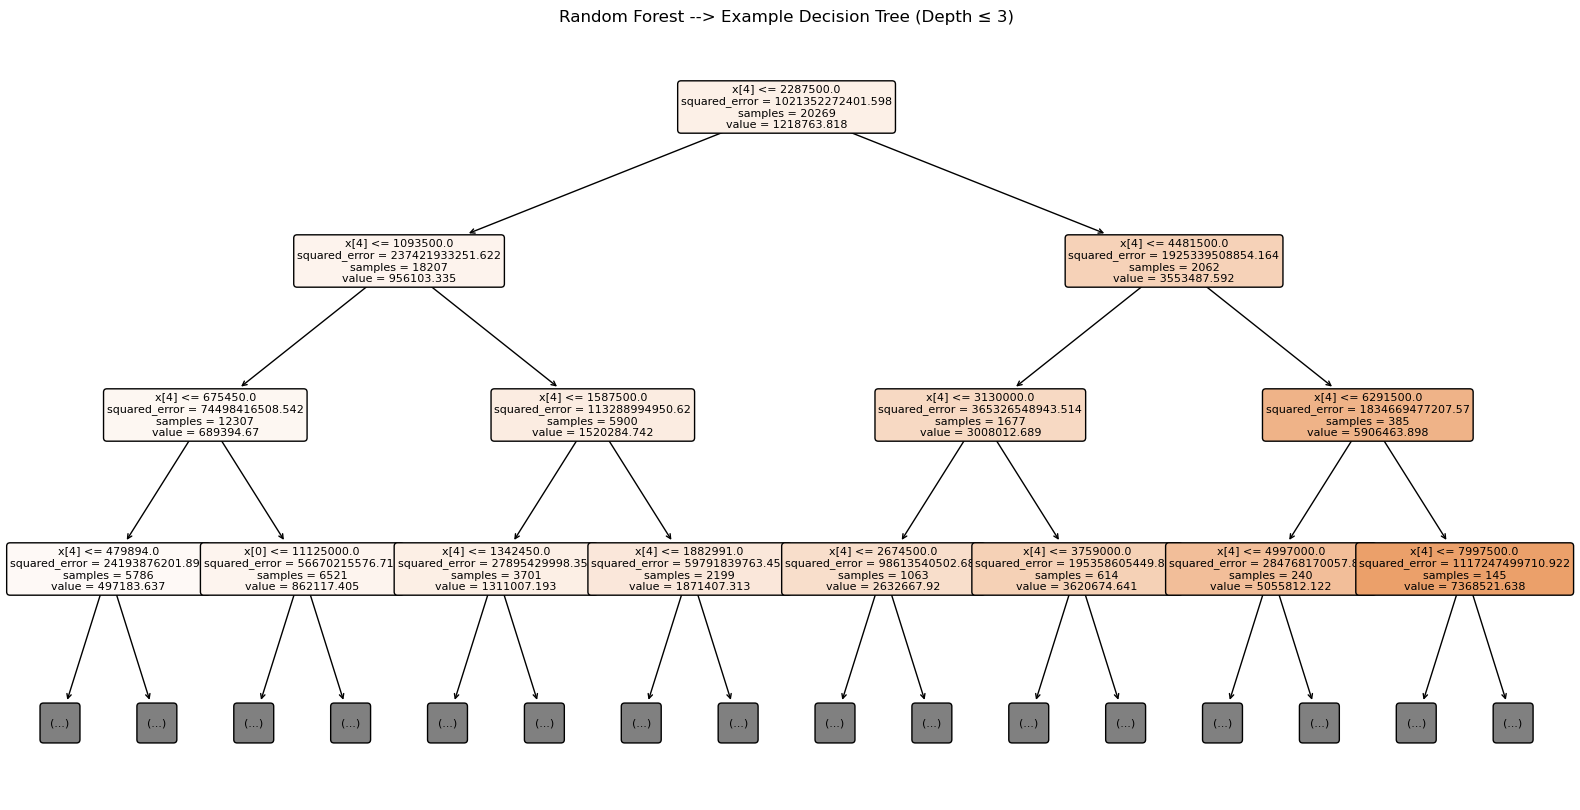

In [15]:
# Visualize one tree using matplotlib 
plt.figure(figsize=(20, 10))
tree.plot_tree(
    rf_model.estimators_[0],
    filled=True,
    rounded=True,
    max_depth=3,   # Keep this small to avoid crash (e.g., 3–4)
    fontsize=8
)
plt.title("Random Forest --> Example Decision Tree (Depth ≤ 3)")
plt.show()

In [16]:
# Feature importance extraction and safety guard
importances = rf_model.feature_importances_

# Try to extract proper column names from the RF preprocessor
rf_pre = rf_tuned.named_steps["prep"]
try:
    feat_names_out = rf_pre.get_feature_names_out()
except Exception:
    # fallback: just use num_cols + cat_cols order
    feat_names_out = np.array(num_cols + cat_cols)

# Ensure lengths match (can happen if preprocessing drops some cols)
if len(importances) != len(feat_names_out):
    print(f"⚠️ Warning: length mismatch ({len(importances)} vs {len(feat_names_out)}). Using generic names.")
    feat_names_out = np.array([f"f{i}" for i in range(len(importances))])

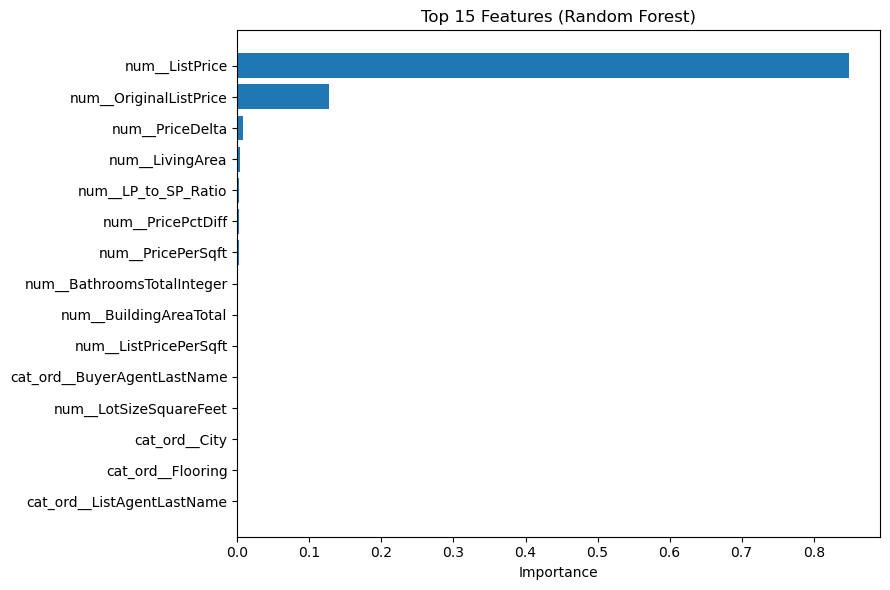

In [17]:
# Sort and display top importances
sorted_idx = np.argsort(importances)[::-1]
top_n = min(15, len(importances))

plt.figure(figsize=(9, 6))
plt.barh(range(top_n), importances[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), feat_names_out[sorted_idx[:top_n]][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features (Random Forest)")
plt.tight_layout()
plt.show()

In [18]:
print("\nTop 10 features:")
for i in range(min(10, len(importances))):
    j = sorted_idx[i]
    print(f"{feat_names_out[j]:<30} {importances[j]:.4f}")
print("Sum of importances:", importances.sum())


Top 10 features:
num__ListPrice                 0.8496
num__OriginalListPrice         0.1267
num__PriceDelta                0.0085
num__LivingArea                0.0037
num__LP_to_SP_Ratio            0.0029
num__PricePctDiff              0.0028
num__PricePerSqft              0.0022
num__BathroomsTotalInteger     0.0013
num__BuildingAreaTotal         0.0009
num__ListPricePerSqft          0.0002
Sum of importances: 1.0000000000000002


#### 7. Save Artifacts

In [19]:
# Save results + best tuned model 
models_path = Path("../models")

# Persist results
res_df.to_csv(models_path / "baseline_models_results.csv", index=False)
with open(models_path / "baseline_models_summary.json", "w") as f:
    json.dump(res_df.to_dict(orient="records"), f, indent=2)

# Pick the winner by RMSE and save the actual best model
best_row = res_df.iloc[0]
best_name = best_row["Model"]
best_pipe = ridge_tuned if "Ridge" in best_name else rf_tuned

joblib.dump(best_pipe, models_path / "best_model.joblib")
print(f"Winner → {best_name}")
print("Saved:", (models_path / "best_model.joblib").resolve())

Winner → RandomForest (tuned)
Saved: /Users/stephanie/Desktop/Home_Price_Predictions/models/best_model.joblib


### Property Price Prediction Example

In [20]:
# Load best model & expected cols for consistent schema --> for predicting API
with open(models_path / "expected_feature_columns.json") as f:
    EXPECTED_COLS = json.load(f)

try:
    BEST_MODEL = joblib.load(models_path / "best_model.joblib")
except Exception as e:
    print("Warning: couldn't load best_model.joblib; using rf_tuned fallback.", e)
    BEST_MODEL = rf_tuned

def predict_price(raw_features: dict, model=BEST_MODEL):
    row = {c: raw_features.get(c, np.nan) for c in EXPECTED_COLS}
    X_new = pd.DataFrame([row], columns=EXPECTED_COLS)
    return float(model.predict(X_new)[0])

In [21]:
# Example new property --> I fill it with typical feature values from dataset
example_house = {
    "BedroomsTotal": 3,
    "BathroomsFull": 2,
    "LivingArea": 1600,
    "LotSizeArea": 5000,
    "GarageSpaces": 2,
    "YearBuilt": 1995,
    "PostalCode": "92618"
}
price = predict_price(example_house)
print(f"\nPredicted Close Price (example): ${price:,.0f}")


Predicted Close Price (example): $899,005


Using the trained Random Forest model, we can now predict the close price of a property 
given its characteristics (bedrooms, bathrooms, square footage, etc.).

This completes the full machine learning workflow from data cleaning, preprocessing, 
and model selection to training, evaluation, and final prediction.

#### 8. Inference Check

In [22]:
X_sample = X_test.head(5)
print("Predictions sample:", rf_tuned.predict(X_sample))

Predictions sample: [ 296841.37604248 1175777.74323118 1224882.82485619 5046643.19645172
  902416.08725033]


#### Evaluate on the August 2025 holdout

In [23]:
import numpy as np, pandas as pd, json, joblib
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def mdape(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mask = (y_true != 0) & np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask): 
        return np.nan
    return float(np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

df_all = pd.read_csv(csv_path)

# 2) Resolve target/date columns
target = next((c for c in target_candidates if c in df_all.columns), None)
assert target is not None, "Target column not found."

date_candidates = [
    "CloseDate","Close Date","Close_Date","CLOSEDATE",
    "CloseOfEscrowDate","COEDate","COE",
    "ModificationTimestamp","ListAgentMlsIdDate","RecordingDate",
    "Period","period","Month","SaleMonth","month"
]
date_col = next((c for c in date_candidates if c in df_all.columns), None)
if date_col is not None:
    df_aug = df_all.copy()
    if date_col.lower() in {"period","month","salemonth"}:
        s = df_aug[date_col].astype(str).str.replace(r"[^\d]", "", regex=True)
        mask_aug = (s.str.len() >= 6) & (s.str[-6:] == "202508")
    else:
        dt = pd.to_datetime(df_aug[date_col], errors="coerce", utc=False)
        mask_aug = (dt.dt.year == 2025) & (dt.dt.month == 8)

    df_aug = df_aug.loc[mask_aug].copy()
    if len(df_aug) > 0:
        X_aug = pd.DataFrame({c: df_aug.get(c, np.nan) for c in EXPECTED_COLS})
        y_aug = pd.to_numeric(df_aug[target], errors="coerce")
        mask_valid = y_aug.notna()
        X_aug, y_aug = X_aug.loc[mask_valid], y_aug.loc[mask_valid]

        if len(y_aug) > 0:
            y_pred = BEST_MODEL.predict(X_aug)
            r2   = float(r2_score(y_aug, y_pred))
            mae  = float(mean_absolute_error(y_aug, y_pred))
            rmse = float(mean_squared_error(y_aug, y_pred, squared=False))
            mda  = mdape(y_aug, y_pred)

            print(f"\nAugust 2025 evaluation — n={len(y_aug)}")
            print(f"R²:    {r2:.4f}")
            print(f"MAE:   {mae:,.0f}")
            print(f"RMSE:  {rmse:,.0f}")
            print(f"MdAPE: {mda:.2f}%")
        else:
            print("\nAugust 2025 evaluation skipped: no valid target values.")
    else:
        print("\nAugust 2025 evaluation skipped: no rows for Aug 2025 in dataset.")
else:
    print("\nHoldout evaluation skipped: no usable date/month column found.")



August 2025 evaluation — n=11439
R²:    0.9903
MAE:   9,544
RMSE:  95,982
MdAPE: 0.08%
